# 00__calc_splicing

in this notebook, i calculate splicing efficiency for each gene using the ENCODE RNA-seq results

no figures or tables in this notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
expr_dir = "../../../misc/07__ENCODE_expr"

In [4]:
gene_sub = "w_gene"
tx_sub = "tx_only"

In [5]:
# seq_counts_f = "../../../data/00__rna_seq/00__sleuth_results/sleuth_abundances_raw_counts.TRANSCRIPTS_WITH_GENE_ISOFORM.txt"

In [6]:
gene_map_f = "../../../misc/00__gene_metadata/gencode.v25lift37.GENE_ID_TRANSCRIPT_ID_MAP.with_DIGIT.fixed.txt"

In [7]:
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

## 1. import data

In [8]:
files = [x[2] for x in os.walk(expr_dir)]
samps = set([x.split(".")[0] for x in files[0] if "kallisto" in x])
samps

{'A549_1_1',
 'A549_2_1',
 'A549_3_1',
 'A549_4_1',
 'GM12878_1_1',
 'GM12878_2_1',
 'H1_1_1',
 'HT1080_1_1',
 'HT1080_2_1',
 'HUES64_1_3',
 'IMR-90_1_1',
 'IMR-90_2_1',
 'K562_1_1',
 'K562_2_1',
 'MCF-7_3_1',
 'MCF-7_4_1',
 'NCI-H460_1_1',
 'NCI-H460_2_1',
 'SK-MEL-5_1_1',
 'SK-MEL-5_2_1',
 'SK-N-DZ_1_1',
 'SK-N-DZ_2_1',
 'SK-N-SH_3_1',
 'SK-N-SH_4_1'}

In [9]:
for i, samp in enumerate(samps):
    print(samp)
    tx_path = "%s/%s.%s.kallisto.tsv" % (expr_dir, samp, tx_sub)
    gene_path = "%s/%s.%s.kallisto.tsv" % (expr_dir, samp, gene_sub)
    if i == 0:
        tx_df = pd.read_table(tx_path, sep="\t")[["target_id", "tpm"]]
        tx_df.columns = ["target_id", samp]
        gene_df = pd.read_table(gene_path, sep="\t")[["target_id", "tpm"]]
        gene_df.columns = ["target_id", samp]
    else:
        tx_tmp = pd.read_table(tx_path, sep="\t")[["target_id", "tpm"]]
        tx_tmp.columns = ["target_id", samp]
        gene_tmp = pd.read_table(gene_path, sep="\t")[["target_id", "tpm"]]
        gene_tmp.columns = ["target_id", samp]
        
        tx_df = tx_df.merge(tx_tmp, on="target_id")
        gene_df = gene_df.merge(gene_tmp, on="target_id")

tx_df.head()

HT1080_2_1
SK-MEL-5_1_1
K562_1_1
SK-N-SH_3_1
HT1080_1_1
H1_1_1
A549_4_1
SK-N-DZ_2_1
GM12878_2_1
SK-N-SH_4_1
A549_3_1
A549_2_1
K562_2_1
MCF-7_4_1
A549_1_1
IMR-90_2_1
NCI-H460_2_1
NCI-H460_1_1
HUES64_1_3
GM12878_1_1
SK-MEL-5_2_1
IMR-90_1_1
MCF-7_3_1
SK-N-DZ_1_1


,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,A549_1_1,IMR-90_2_1,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1
0,ENST00000456328.2_1,0.691339,1.15116,0.313936,0.334105,0.487667,0.004047,0.763808,5.64779,0.034047,...,0.573798,0.026795,1.235340,0.659146,0.008846,0.017293,0.769937,0.072287,0.720683,4.806000
1,ENST00000450305.2_1,0.000000,0.00000,0.000000,0.000000,0.000000,0.019143,0.000000,0.00000,0.031573,...,0.000000,0.000000,0.341847,0.000000,0.000000,0.002571,0.048903,0.000000,0.000000,0.046717
2,ENST00000488147.1_1,23.152300,40.79530,13.862000,18.962000,22.800500,4.382520,11.502300,50.83590,3.035160,...,0.000000,19.042100,38.673200,44.566400,0.589062,2.863410,63.416700,15.670100,41.174500,68.040800
3,ENST00000473358.1_1,0.000000,0.00000,0.000000,0.045354,0.000000,0.028021,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENST00000469289.1_1,0.000000,0.00000,0.033696,0.000000,0.000000,0.110995,0.000000,0.00000,0.009972,...,0.000000,0.000000,0.000000,0.000000,0.005711,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# seq_counts = pd.read_table(seq_counts_f).reset_index()
# seq_counts.head()

In [11]:
gene_map = pd.read_table(gene_map_f, header=None)
gene_map.columns = ["gene_id", "transcript_id"]
gene_map.head()

,gene_id,transcript_id
0,ENSG00000223972.5_1,ENST00000456328.2_1
1,ENSG00000223972.5_1,ENST00000450305.2_1
2,ENSG00000227232.5_1,ENST00000488147.1_1
3,ENSG00000243485.4_2,ENST00000473358.1_1
4,ENSG00000243485.4_2,ENST00000469289.1_1


In [12]:
rna_seq = pd.read_table(rna_seq_f)
print(len(rna_seq))
rna_seq.head()

170623


,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


## 2. sep gene & transcripts

In [13]:
gene_counts = gene_df[gene_df["target_id"].str.startswith("ENSG")]
print(len(gene_counts))
gene_counts.sample(5)

60203


,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,A549_1_1,IMR-90_2_1,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1
224932,ENSG00000182010.10_1::chr10:63942794-64028467(-),0.134214,0.051362,0.001258,0.022877,0.103652,0.107054,0.020762,0.387121,0.001413,...,0.057975,0.004916,0.047632,0.065572,0.012069,0.001050,0.085796,0.007712,0.131841,0.320266
236021,ENSG00000259489.2_1::chr15:89503300-89504277(+),0.000000,0.000000,0.002104,0.000000,0.000000,0.004123,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.455176,0.000000,0.001039,0.000000,0.083051,0.000000,0.039995,0.000000
216907,ENSG00000276620.1_1::chr6:107513503-107513777(+),0.000000,0.000000,0.007520,0.000000,0.000000,0.000000,0.064462,0.000000,0.011731,...,0.000000,0.000000,0.173567,0.000000,0.004885,0.000000,0.000000,0.000000,0.003032,0.000000
238749,ENSG00000108528.13_1::chr17:4840425-4843547(-),0.097479,0.114735,0.013834,0.086995,0.410585,0.074358,0.160852,0.355201,0.047637,...,0.087657,0.104803,1.258400,1.580350,0.008864,0.045984,0.175606,0.075087,0.295595,0.333751
221629,ENSG00000254267.1_1::chr8:99383583-99400476(-),0.095784,0.079146,0.011430,0.050677,0.104953,0.045130,0.043491,0.053075,0.016481,...,0.026251,0.004924,0.147682,0.066684,0.005844,0.016237,0.140512,0.007314,0.401417,0.087763


In [14]:
gene_counts = gene_counts.append(gene_df[gene_df["target_id"].str.contains("DIGIT::")])
print(len(gene_counts))

60204


In [15]:
transcript_counts = gene_df[gene_df["target_id"].str.startswith("ENST")]
print(len(transcript_counts))
transcript_counts.sample(5)

200139


,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,A549_1_1,IMR-90_2_1,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1
90056,ENST00000375646.5_1,0.634289,5.28923,0.645261,0.897672,0.113422,1.033560,0.467197,0.00000,0.679288,...,0.592658,0.913994,0.00000,0.000000,0.286717,0.124514,0.00000,1.29125,0.695077,0.000000
55989,ENST00000616007.4_1,0.000000,0.00000,0.000000,0.000000,0.000000,0.019325,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.104746,0.000000,0.008128,0.00000,0.00000,0.000000,0.000000
16635,ENST00000422175.1_1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
121988,ENST00000397075.7_1,5.178490,10.30120,1.829240,17.328900,6.239010,1.401100,19.040600,1.78996,1.234460,...,16.736900,22.388500,9.96627,0.259073,0.323598,1.964900,4.41335,22.60770,17.028400,0.154577
126811,ENST00000554917.5_1,0.000000,0.00000,0.000000,0.044691,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000


In [16]:
transcript_counts = transcript_counts.append(gene_df[gene_df["target_id"] == "DIGIT"])
print(len(transcript_counts))

200140


## 4. make 1 dataframe with gene/transcript counts mapped to gene ids

In [17]:
gene_counts["gene_id"] = gene_counts["target_id"].str.split("::", expand=True)[0]
gene_counts["type"] = "gene"
gene_counts.head()

,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1,gene_id,type
200140,ENSG00000223972.5_1::chr1:11868-14409(+),0.018867,0.0000,0.152498,0.000000,6.377350e-07,0.004712,0.175356,0.839459,0.016021,...,0.276494,7.060170e-02,0.000000,0.001038,0.402920,0.059667,0.054286,1.34005,ENSG00000223972.5_1,gene
200141,ENSG00000227232.5_1::chr1:14404-29571(-),8.013650,11.6066,1.742750,6.811900,7.090820e+00,0.807824,1.476590,15.647600,0.639793,...,18.798600,1.747280e+01,0.139711,0.531770,14.212700,1.292600,9.312720,19.51290,ENSG00000227232.5_1,gene
200142,ENSG00000243485.4_2::chr1:29553-31109(+),0.077854,0.0000,0.080118,0.041129,0.000000e+00,0.078441,0.000000,0.000000,0.000000,...,0.000000,6.189830e-08,0.010377,0.000000,0.689376,0.000000,0.000000,0.00000,ENSG00000243485.4_2,gene
200143,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.0000,0.005424,0.000000,1.410140e-03,0.000066,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000105,0.000000,0.00000,ENSG00000237613.2_1,gene
200144,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.0000,0.004732,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,ENSG00000268020.3_1,gene


In [18]:
transcript_counts["transcript_id"] = transcript_counts["target_id"]
transcript_counts["type"] = "transcript"
transcript_counts.head()

,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1,transcript_id,type
0,ENST00000456328.2_1,0.262934,1.444350,0.084567,0.220057,0.269616,0.000879,0.275527,1.797830,0.002427,...,0.0000,0.733059,0.008837,0.013761,0.135529,0.0000,0.617873,0.001765,ENST00000456328.2_1,transcript
1,ENST00000450305.2_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,ENST00000450305.2_1,transcript
2,ENST00000488147.1_1,28.958800,49.514600,14.784400,20.399800,28.861400,5.105190,14.017000,65.145000,3.469360,...,56.5208,62.705200,0.694039,3.172690,77.177500,16.9903,48.256000,88.337500,ENST00000488147.1_1,transcript
3,ENST00000473358.1_1,0.000000,0.429972,0.000000,0.028681,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,ENST00000473358.1_1,transcript
4,ENST00000469289.1_1,0.000000,0.000000,0.048793,0.297624,0.000000,0.000000,0.000000,0.495686,0.102194,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,ENST00000469289.1_1,transcript


In [19]:
# cols = ["index", "type", "hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]

In [20]:
tot_counts = gene_counts.append(transcript_counts)
tot_counts["id"] = tot_counts["target_id"].str.split("::", expand=True)[0]
tot_counts.drop(["gene_id", "transcript_id"], axis=1, inplace=True)
tot_counts.sample(5)

,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1,type,id
3961,ENST00000471369.1_1,0.0000,0.0000,0.001558,0.137799,0.000,0.000000,0.000000,0.0000,0.051753,...,0.0000,0.0000,0.000000,0.000000,0.334125,0.0000,0.187512,0.000000,transcript,ENST00000471369.1_1
48534,ENST00000503325.1_1,0.0000,0.0000,0.000000,0.094249,0.000,0.000000,0.000000,0.0000,0.000000,...,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.710086,transcript,ENST00000503325.1_1
57308,ENST00000503078.5_1,14.5866,19.7496,1.215590,17.457700,16.431,0.239728,10.221700,14.1943,2.572580,...,19.1289,14.8019,0.078608,1.735680,17.802400,15.1723,31.226200,16.776700,transcript,ENST00000503078.5_1
140794,ENST00000618027.1_1,0.0000,0.0000,0.000000,0.001836,0.000,0.000000,0.195435,0.0000,0.000000,...,0.0000,0.0000,0.001461,0.000000,0.000000,0.0000,0.112290,0.000000,transcript,ENST00000618027.1_1
73522,ENST00000460346.5_1,0.0000,0.0000,0.000000,0.044746,0.000,0.015232,0.000000,0.0000,0.000000,...,0.0000,0.0000,0.000000,0.032462,0.000000,0.0000,0.000000,0.000000,transcript,ENST00000460346.5_1


In [21]:
tot_counts = tot_counts.merge(gene_map, left_on="id", right_on="transcript_id", how="left")
tot_counts.sample(5)

,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1,type,id,gene_id,transcript_id
6790,ENSG00000138382.14_2::chr2:170666591-170681442(-),0.923123,0.622059,0.320797,0.062390,0.749524,0.203707,0.144150,0.790176,0.255242,...,0.010509,0.202967,0.588889,0.043835,0.214027,0.932956,gene,ENSG00000138382.14_2,NaN,NaN
161338,ENST00000449319.2_1,9.091270,6.036060,1.799240,8.966950,10.757800,1.184900,10.214700,17.657000,1.832990,...,0.381516,1.898470,6.685630,11.210700,16.234800,13.219100,transcript,ENST00000449319.2_1,ENSG00000176973.7_2,ENST00000449319.2_1
230318,ENST00000601015.5_1,0.000000,0.000000,0.000000,0.043745,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.043513,0.000000,transcript,ENST00000601015.5_1,ENSG00000142546.13_2,ENST00000601015.5_1
133904,ENST00000453822.1_1,0.003661,0.078994,0.010434,0.000363,0.003809,0.000000,0.000000,0.000000,0.004364,...,0.000000,0.005057,0.035616,0.000000,0.000000,0.000000,transcript,ENST00000453822.1_1,ENSG00000231244.1_1,ENST00000453822.1_1
32295,ENSG00000280734.2_1::chr13:100139216-100151561(-),0.228979,0.549144,0.119548,0.143886,0.254544,0.129273,0.076871,0.181035,0.412818,...,0.010902,0.308587,0.859398,0.018622,0.406029,0.182212,gene,ENSG00000280734.2_1,NaN,NaN


In [22]:
def fill_gene_id(row):
    if pd.isnull(row["gene_id"]):
        return row["id"]
    else:
        return row["gene_id"]
    
tot_counts["gene_id"] = tot_counts.apply(fill_gene_id, axis=1)
tot_counts.sample(5)

,target_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1,type,id,gene_id,transcript_id
216525,ENST00000571570.5_1,0.42220,0.000000,0.072046,0.165014,0.000000,0.000178,0.038079,0.00000,0.082657,...,0.154429,0.116858,0.000000,0.183941,0.269987,0.000000,transcript,ENST00000571570.5_1,ENSG00000141552.17_2,ENST00000571570.5_1
107586,ENST00000508116.5_1,0.66403,12.812900,0.000000,0.025758,0.427036,0.002893,1.257290,0.00000,0.161999,...,0.003318,0.035361,17.897300,0.525271,8.205400,0.000000,transcript,ENST00000508116.5_1,ENSG00000109452.12_2,ENST00000508116.5_1
176913,ENST00000542440.5_1,6.10464,9.458000,2.504370,2.104100,5.516240,2.468120,3.819340,3.66518,1.457420,...,0.396872,1.459740,6.858990,2.184060,6.700150,2.935270,transcript,ENST00000542440.5_1,ENSG00000139718.10_1,ENST00000542440.5_1
218219,ENST00000585908.2_1,0.00000,3.879320,0.000000,0.986491,0.000000,4.943500,1.620400,0.00000,0.421324,...,0.044453,0.347425,1.824350,0.049523,0.879639,0.000000,transcript,ENST00000585908.2_1,ENSG00000154065.16_1,ENST00000585908.2_1
550,ENSG00000117242.7_2::chr1:20969150-20978687(-),0.77274,0.000118,0.079766,0.677499,0.938969,0.222010,0.368454,0.45805,0.160740,...,0.028531,0.136591,0.000853,0.604501,0.328477,0.763696,gene,ENSG00000117242.7_2,ENSG00000117242.7_2,NaN


In [23]:
cols = ["id", "gene_id", "type"]
cols.extend(samps)

tot_counts = tot_counts[cols]
tot_counts = tot_counts.sort_values(by="gene_id")
tot_counts.head()

,id,gene_id,type,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,...,A549_1_1,IMR-90_2_1,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1
260343,DIGIT,DIGIT,transcript,0.000000,0.000000,0.000000,0.023549,0.000000,0.007726,0.000000,...,0.000000,0.000000,0.00000,0.837391,0.007827,0.00000,0.000000,0.002972,0.249567,0.000000
60203,DIGIT,DIGIT,gene,0.000000,0.000000,0.000000,0.011484,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.41413,0.027587,0.004732,0.00000,0.000000,0.000000,0.206487,0.000000
246632,ENST00000373020.8_1,ENSG00000000003.14_1,transcript,12.688600,23.240900,0.006845,15.125800,12.789700,33.727600,46.086500,...,129.732000,6.465360,28.67390,23.166600,3.975540,0.00834,24.082400,7.668360,12.106000,0.599449
246633,ENST00000614008.4_1,ENSG00000000003.14_1,transcript,1.113430,0.000000,0.000000,0.000000,0.704090,0.165611,0.412471,...,0.587522,0.000000,2.72007,0.000000,0.050411,0.00000,0.728174,0.000000,0.464117,0.000000
246634,ENST00000496771.5_1,ENSG00000000003.14_1,transcript,0.461149,0.537843,0.005505,1.315480,0.190501,0.337274,1.421460,...,1.581980,0.195743,1.32613,3.728680,0.192082,0.00000,1.732210,0.268577,0.348396,1.071130


## 5. sum counts per gene (incl. gene isoform and all transcripts)

In [24]:
sum_counts = tot_counts.groupby("gene_id")[list(samps)].agg("sum").reset_index()
sum_counts.head()

,gene_id,HT1080_2_1,SK-MEL-5_1_1,K562_1_1,SK-N-SH_3_1,HT1080_1_1,H1_1_1,A549_4_1,SK-N-DZ_2_1,GM12878_2_1,...,A549_1_1,IMR-90_2_1,NCI-H460_2_1,NCI-H460_1_1,HUES64_1_3,GM12878_1_1,SK-MEL-5_2_1,IMR-90_1_1,MCF-7_3_1,SK-N-DZ_1_1
0,DIGIT,0.000000,0.000000,0.000000,0.035033,0.000000,0.007726,0.000000,0.004493,0.000000,...,0.000000,0.000000,0.414130,0.864978,0.012559,0.000000,0.000000,0.002972,0.456054,0.000000
1,ENSG00000000003.14_1,14.541504,24.246197,0.012643,16.992889,13.817025,35.839692,48.139152,1.686872,0.011580,...,133.533676,6.945778,33.688683,28.055113,4.312077,0.016676,26.945229,8.275706,13.036760,1.751627
2,ENSG00000000005.5_1,0.000000,0.000000,0.000000,0.000163,0.000000,2.058903,0.000904,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.229551,0.000000,0.000000,0.000391,0.001127,0.000000
3,ENSG00000000419.12_1,136.635031,71.949707,135.290452,69.637735,134.609196,28.357671,44.527992,300.970130,87.882893,...,69.847103,33.838342,124.338954,181.760640,4.725570,87.818252,71.786449,42.575755,146.445427,246.059250
4,ENSG00000000457.13_1,8.792988,9.618897,3.939202,6.872076,8.442258,1.757401,3.468668,9.435939,6.201278,...,7.024126,1.824338,10.623403,6.859320,0.295608,5.654283,7.121389,2.204203,11.257167,10.351289


## 6. calculate splicing efficiency

In [25]:
len(gene_counts)

60204

In [26]:
len(sum_counts)

60253

In [27]:
data = gene_counts.merge(sum_counts, on="gene_id", suffixes=("_gene", "_tot"))
data.head()

,target_id,HT1080_2_1_gene,SK-MEL-5_1_1_gene,K562_1_1_gene,SK-N-SH_3_1_gene,HT1080_1_1_gene,H1_1_1_gene,A549_4_1_gene,SK-N-DZ_2_1_gene,GM12878_2_1_gene,...,A549_1_1_tot,IMR-90_2_1_tot,NCI-H460_2_1_tot,NCI-H460_1_1_tot,HUES64_1_3_tot,GM12878_1_1_tot,SK-MEL-5_2_1_tot,IMR-90_1_1_tot,MCF-7_3_1_tot,SK-N-DZ_1_1_tot
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.018867,0.0000,0.152498,0.000000,6.377350e-07,0.004712,0.175356,0.839459,0.016021,...,0.359035,0.026873,0.276494,8.036607e-01,0.008837,0.014799,0.538449,0.059667,0.672159,1.341815
1,ENSG00000227232.5_1::chr1:14404-29571(-),8.013650,11.6066,1.742750,6.811900,7.090820e+00,0.807824,1.476590,15.647600,0.639793,...,0.644312,21.522750,75.319400,8.017800e+01,0.833750,3.704460,91.390200,18.282900,57.568720,107.850400
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.077854,0.0000,0.080118,0.041129,0.000000e+00,0.078441,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.189830e-08,0.010377,0.000000,0.689376,0.000000,0.000000,0.000000
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.0000,0.005424,0.000000,1.410140e-03,0.000066,0.000000,0.000000,0.000000,...,0.000000,0.000129,0.000000,0.000000e+00,0.000050,0.000000,0.000000,0.178666,0.000000,0.445219
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.0000,0.004732,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
for samp in samps:
    data["%s_eff" % samp] = 1-((data["%s_gene" % samp]+1)/(data["%s_tot" % samp]+1))
data.head()

,target_id,HT1080_2_1_gene,SK-MEL-5_1_1_gene,K562_1_1_gene,SK-N-SH_3_1_gene,HT1080_1_1_gene,H1_1_1_gene,A549_4_1_gene,SK-N-DZ_2_1_gene,GM12878_2_1_gene,...,A549_1_1_eff,IMR-90_2_1_eff,NCI-H460_2_1_eff,NCI-H460_1_1_eff,HUES64_1_3_eff,GM12878_1_1_eff,SK-MEL-5_2_1_eff,IMR-90_1_1_eff,MCF-7_3_1_eff,SK-N-DZ_1_1_eff
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.018867,0.0000,0.152498,0.000000,6.377350e-07,0.004712,0.175356,0.839459,0.016021,...,0.264184,0.026170,0.000000,0.406428,0.008760,0.013561,0.088095,0.000000,0.369506,0.000754
1,ENSG00000227232.5_1::chr1:14404-29571(-),8.013650,11.6066,1.742750,6.811900,7.090820e+00,0.807824,1.476590,15.647600,0.639793,...,0.000000,0.907656,0.740582,0.772441,0.378481,0.674400,0.835343,0.881107,0.823921,0.811550
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.077854,0.0000,0.080118,0.041129,0.000000e+00,0.078441,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.0000,0.005424,0.000000,1.410140e-03,0.000066,0.000000,0.000000,0.000000,...,0.000000,0.000129,0.000000,0.000000,0.000050,0.000000,0.000000,0.151494,0.000000,0.308063
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.0000,0.004732,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
cells = set([x.split("_")[0] for x in samps])
cells

{'A549',
 'GM12878',
 'H1',
 'HT1080',
 'HUES64',
 'IMR-90',
 'K562',
 'MCF-7',
 'NCI-H460',
 'SK-MEL-5',
 'SK-N-DZ',
 'SK-N-SH'}

In [30]:
for cell in cells:
    sub_cols = ["%s_eff" % x for x in samps if cell in x]
    print("cell: %s, samps: %s" % (cell, sub_cols))
    data["%s_eff_mean" % cell] = data[sub_cols].mean(axis=1)
    sub_cols = ["%s_tot" % x for x in samps if cell in x]
    data["%s_exp_mean" % cell] = data[sub_cols].mean(axis=1)
    
    # also record the ratio of expr & splicing efficiency (eff * expr)
    data["%s_eff_ratio" % cell] = data["%s_eff_mean" % cell] * data["%s_exp_mean" % cell]
data.head()

cell: SK-N-SH, samps: ['SK-N-SH_3_1_eff', 'SK-N-SH_4_1_eff']
cell: NCI-H460, samps: ['NCI-H460_2_1_eff', 'NCI-H460_1_1_eff']
cell: K562, samps: ['K562_1_1_eff', 'K562_2_1_eff']
cell: HT1080, samps: ['HT1080_2_1_eff', 'HT1080_1_1_eff']
cell: SK-N-DZ, samps: ['SK-N-DZ_2_1_eff', 'SK-N-DZ_1_1_eff']
cell: GM12878, samps: ['GM12878_2_1_eff', 'GM12878_1_1_eff']
cell: MCF-7, samps: ['MCF-7_4_1_eff', 'MCF-7_3_1_eff']
cell: HUES64, samps: ['HUES64_1_3_eff']
cell: IMR-90, samps: ['IMR-90_2_1_eff', 'IMR-90_1_1_eff']
cell: A549, samps: ['A549_4_1_eff', 'A549_3_1_eff', 'A549_2_1_eff', 'A549_1_1_eff']
cell: SK-MEL-5, samps: ['SK-MEL-5_1_1_eff', 'SK-MEL-5_2_1_eff']
cell: H1, samps: ['H1_1_1_eff']


,target_id,HT1080_2_1_gene,SK-MEL-5_1_1_gene,K562_1_1_gene,SK-N-SH_3_1_gene,HT1080_1_1_gene,H1_1_1_gene,A549_4_1_gene,SK-N-DZ_2_1_gene,GM12878_2_1_gene,...,IMR-90_eff_ratio,A549_eff_mean,A549_exp_mean,A549_eff_ratio,SK-MEL-5_eff_mean,SK-MEL-5_exp_mean,SK-MEL-5_eff_ratio,H1_eff_mean,H1_exp_mean,H1_eff_ratio
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.018867,0.0000,0.152498,0.000000,6.377350e-07,0.004712,0.175356,0.839459,0.016021,...,0.000566,0.165392,0.324782,0.053717,0.339494,0.991399,0.336574,0.000874,0.005592,4.888875e-06
1,ENSG00000227232.5_1::chr1:14404-29571(-),8.013650,11.6066,1.742750,6.811900,7.090820e+00,0.807824,1.476590,15.647600,0.639793,...,17.800715,0.431375,9.818135,4.235293,0.816204,76.255700,62.240184,0.738490,5.913014,4.366700e+00
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.077854,0.0000,0.080118,0.041129,0.000000e+00,0.078441,0.000000,0.000000,0.000000,...,0.000000,0.011414,0.011960,0.000137,0.150343,0.559674,0.084143,0.000000,0.078441,0.000000e+00
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.0000,0.005424,0.000000,1.410140e-03,0.000066,0.000000,0.000000,0.000000,...,0.006777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000270,0.000336,9.057858e-08
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.0000,0.004732,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [31]:
data["gene_id"] = data.target_id.str.split("::", expand=True)[0]

clean_cols = ["gene_id"]
clean_cols.extend([x for x in data.columns if "_mean" in x or "_ratio" in x])
data = data[clean_cols]
data.head()

,gene_id,SK-N-SH_eff_mean,SK-N-SH_exp_mean,SK-N-SH_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,...,IMR-90_eff_ratio,A549_eff_mean,A549_exp_mean,A549_eff_ratio,SK-MEL-5_eff_mean,SK-MEL-5_exp_mean,SK-MEL-5_eff_ratio,H1_eff_mean,H1_exp_mean,H1_eff_ratio
0,ENSG00000223972.5_1,0.221426,0.380645,8.428480e-02,0.203214,5.400774e-01,0.109751,0.076807,0.165145,0.012684,...,0.000566,0.165392,0.324782,0.053717,0.339494,0.991399,0.336574,0.000874,0.005592,4.888875e-06
1,ENSG00000227232.5_1,0.712308,29.057110,2.069760e+01,0.756512,7.774870e+01,58.817792,0.836983,16.803705,14.064423,...,17.800715,0.431375,9.818135,4.235293,0.816204,76.255700,62.240184,0.738490,5.913014,4.366700e+00
2,ENSG00000243485.4_2,0.208126,0.319514,6.649922e-02,0.000000,3.094915e-08,0.000000,0.038730,0.115228,0.004463,...,0.000000,0.011414,0.011960,0.000137,0.150343,0.559674,0.084143,0.000000,0.078441,0.000000e+00
3,ENSG00000237613.2_1,0.000005,0.000032,1.654360e-10,0.000000,0.000000e+00,0.000000,0.014606,0.032696,0.000478,...,0.006777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000270,0.000336,9.057858e-08
4,ENSG00000268020.3_1,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.007864,0.016022,0.000126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


## 7. merge w/ biotype info

In [32]:
biotypes = rna_seq[["gene_id", "gene_name", "csf", "cleaner_gene_biotype"]].drop_duplicates()
print(len(biotypes))
biotypes.head()

33856


,gene_id,gene_name,csf,cleaner_gene_biotype
0,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap
1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding
2,ENSG00000003056.3,M6PR,protein_coding,protein_coding
3,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding
4,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding


In [33]:
data = data.merge(biotypes, on="gene_id", how="left")
print(len(data))
data.sample(5)

60204


,gene_id,SK-N-SH_eff_mean,SK-N-SH_exp_mean,SK-N-SH_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,...,A549_eff_ratio,SK-MEL-5_eff_mean,SK-MEL-5_exp_mean,SK-MEL-5_eff_ratio,H1_eff_mean,H1_exp_mean,H1_eff_ratio,gene_name,csf,cleaner_gene_biotype
46968,ENSG00000211662.2_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000008,0.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN
52080,ENSG00000252442.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN
14598,ENSG00000186335.8_1,0.000000,0.000320,0.000000,0.004717,0.004762,0.000022,0.003799,0.008484,0.000032,...,0.000006,0.0,0.002839,0.0,0.015840,0.018035,0.000286,SLC36A2,protein_coding,protein_coding
40230,ENSG00000249838.1_1,0.022469,0.049376,0.001109,0.000000,0.000000,0.000000,0.016074,0.034357,0.000552,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN
3226,ENSG00000117601.13_1,0.068865,0.082990,0.005715,0.000000,0.040891,0.000000,0.266144,0.378073,0.100622,...,0.006185,0.0,0.007488,0.0,0.019051,0.025365,0.000483,SERPINC1,protein_coding,protein_coding


## 9. some QC plots

In [34]:
data.cleaner_gene_biotype.value_counts()

protein_coding        20132
transcript_overlap     6594
intergenic             4615
promoter_overlap       2262
gene_nearby             253
Name: cleaner_gene_biotype, dtype: int64

In [35]:
order = ["protein_coding", "intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby"]
pal = {"protein_coding": sns.color_palette("deep")[0], "intergenic": "firebrick", "promoter_overlap": "firebrick",
       "transcript_overlap": "firebrick", "gene_nearby": "firebrick"}

In [36]:
sorted(list(cells))

['A549',
 'GM12878',
 'H1',
 'HT1080',
 'HUES64',
 'IMR-90',
 'K562',
 'MCF-7',
 'NCI-H460',
 'SK-MEL-5',
 'SK-N-DZ',
 'SK-N-SH']

Text(0.05, 0.5, 'splicing efficiency in:')

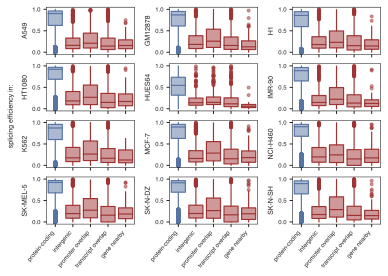

In [37]:
fig, axarr = plt.subplots(figsize=(6, 4), nrows=4, ncols=3, sharex=True)

c = 0
for i in range(4):
    for j in range(3):
        col = sorted(list(cells))[c]

        sub = data[data["%s_exp_mean" % col] >= 0.1]
        ax = axarr[i, j]

        sns.boxplot(data=sub, x="cleaner_gene_biotype", y="%s_eff_mean" % col, order=order, palette=pal,
                    flierprops=dict(marker='o', markersize=3), ax=ax)
        mimic_r_boxplot(ax)

        ax.set_xlabel("")
        ax.set_ylabel(col)
        ax.set_xticklabels(["protein-coding", "intergenic", "promoter overlap", "transcript overlap", "gene nearby"],
                           rotation=50, ha="right", va="top")
        c += 1

plt.subplots_adjust(wspace=0.4)
plt.text(0.05, 0.5, 'splicing efficiency in:',
         horizontalalignment='right',
         verticalalignment='center',
         rotation='vertical',
         transform=plt.gcf().transFigure)

#fig.savefig("splicing_eff_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [38]:
eff_cols = [x for x in data.columns if "eff" in x and "ratio" not in x]
exp_cols = [x for x in data.columns if "exp" in x]
ratio_cols = [x for x in data.columns if "ratio" in x]

data["max_eff"] = data[eff_cols].max(axis=1)
data["max_exp"] = data[exp_cols].max(axis=1)
data["max_ratio"] = data[ratio_cols].max(axis=1)
data.head()

,gene_id,SK-N-SH_eff_mean,SK-N-SH_exp_mean,SK-N-SH_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,...,SK-MEL-5_eff_ratio,H1_eff_mean,H1_exp_mean,H1_eff_ratio,gene_name,csf,cleaner_gene_biotype,max_eff,max_exp,max_ratio
0,ENSG00000223972.5_1,0.221426,0.380645,8.428480e-02,0.203214,5.400774e-01,0.109751,0.076807,0.165145,0.012684,...,0.336574,0.000874,0.005592,4.888875e-06,NaN,NaN,NaN,0.339494,1.989552,0.492445
1,ENSG00000227232.5_1,0.712308,29.057110,2.069760e+01,0.756512,7.774870e+01,58.817792,0.836983,16.803705,14.064423,...,62.240184,0.738490,5.913014,4.366700e+00,NaN,NaN,NaN,0.894381,94.321500,75.835208
2,ENSG00000243485.4_2,0.208126,0.319514,6.649922e-02,0.000000,3.094915e-08,0.000000,0.038730,0.115228,0.004463,...,0.084143,0.000000,0.078441,0.000000e+00,MIR1302-2,lncRNA_good_csf,intergenic,0.208126,0.559674,0.084143
3,ENSG00000237613.2_1,0.000005,0.000032,1.654360e-10,0.000000,0.000000e+00,0.000000,0.014606,0.032696,0.000478,...,0.000000,0.000270,0.000336,9.057858e-08,FAM138A,lncRNA_good_csf,intergenic,0.154032,0.222609,0.034289
4,ENSG00000268020.3_1,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.007864,0.016022,0.000126,...,0.000000,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,0.007864,0.016022,0.000126


## 10. write file

In [40]:
data_f = "../../../misc/09__model_features/gene_splicing_efficiency.with_DIGIT.txt"
data.to_csv(data_f, index=False, sep="\t")